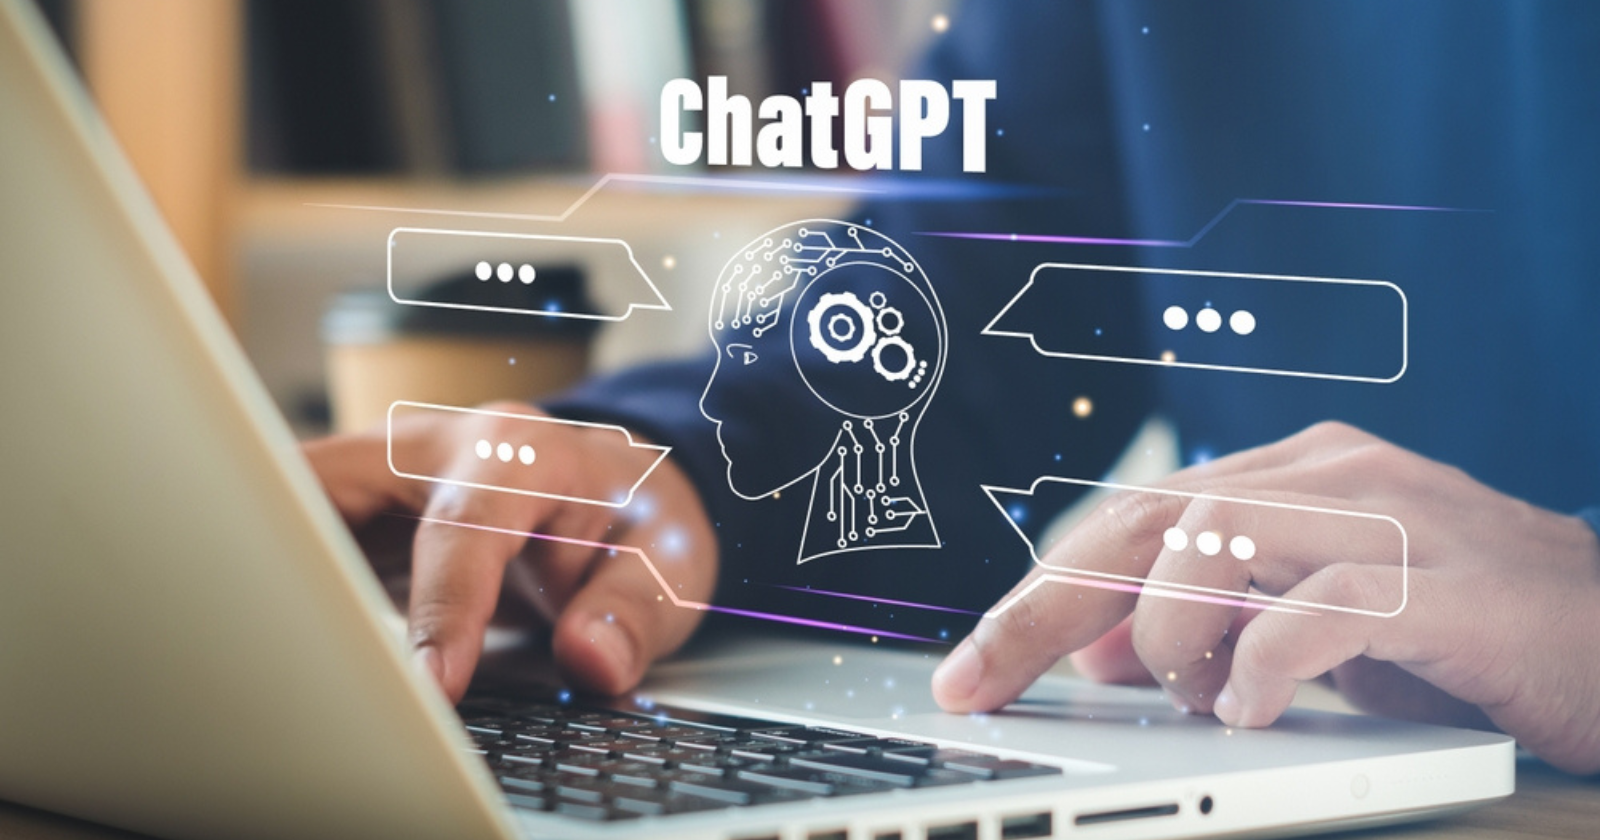

* ***Analyzing the sentiments expressed in tweets about ChatGPT is a project of substantial importance, offering valuable insights into public perception and feedback. In today's digital age, social media platforms like Twitter serve as hubs for the exchange of opinions and experiences, making them an essential source of information for businesses and organizations. The sentiment of tweets provides a direct window into how people perceive and interact with products and services, in this case, ChatGPT. Understanding these sentiments is crucial for several reasons.***

* ***First and foremost, the sentiment of tweets can be indicative of customer satisfaction, which is pivotal for businesses. Positive sentiments can reflect high levels of contentment and may serve as endorsements, while negative sentiments may highlight areas for improvement. By harnessing sentiment analysis, companies can adapt their strategies, address concerns, and capitalize on strengths, ultimately enhancing the customer experience.***

* ***Secondly, sentiment analysis enables businesses to stay attuned to market trends and competition. It aids in identifying emerging issues and sentiments surrounding competing products or services. By closely monitoring ChatGPT-related tweets, companies can make informed decisions and adapt their offerings accordingly.***

* ***Additionally, sentiment analysis on Twitter can help in crisis management. If there's a sudden surge of negative sentiments related to ChatGPT, it can signal a potential issue that needs immediate attention, allowing companies to take corrective actions promptly.***

* ***In summary, the sentiment of tweets is a powerful indicator of customer perceptions, market dynamics, and potential issues, making it an invaluable resource for businesses and organizations seeking to enhance their products and services. This project aims to tap into this valuable data source and extract actionable insights from the sentiments expressed in tweets about ChatGPT.***

### Import Required Libraries:

In [1]:
import re
import string
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

from wordcloud import WordCloud
from collections import defaultdict,Counter

from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

import keras
from keras.preprocessing.text import *
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import *
from keras.losses import *
from keras.metrics import Precision
from keras import backend
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences
from keras.regularizers import l2

import xgboost

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Loading data using pandas csv reader
# Due to low computer resource, I only import 1,00,000 lakh rows for this project.
df = pd.read_csv('file.csv',usecols = ['tweets','labels'],nrows=100000)

In [3]:
# First five rows wil be displayed:
df.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [4]:
# Last five rows wil be displayed:
df.tail()

,tweets,labels
99995,"if you're creating short form video content, a...",good
99996,(@)sonofmosiah:\nDid OpenAI really market Chat...,good
99997,How to Code Web 3.0 Apps with ChatGPT A.I. #Ch...,bad
99998,"Actually, you can serve ads profitably off of ...",good
99999,"Chatbot ChatGPT writes poetry, prose and compu...",good


In [5]:
# Basic Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  100000 non-null  object
 1   labels  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [6]:
# No missing values.
# There are totally 100000 tweets about chatgpt has been collected and the emotion for each tweet has been labelled.
# Both the features are belong to the object data type.

In [7]:
df.describe()

,tweets,labels
count,100000,100000
unique,99376,3
top,ChatGPT,bad
freq,66,48914


In [8]:
# The tweets which only contains word chatgpt should be removed.
# The labels might be imbalanced.We'll check how imbalanced it is during the eda process.

In [9]:
df.duplicated().sum()
# There are duplicate rows present in the dataframe.

624

In [10]:
# Lets drop the duplicate rows and reset the index properly
df.drop_duplicates().reset_index(drop = True,inplace = True)

###  Analysis of text :

In [11]:
# I'll use the naive approach to count the number of words in the each sentence(tweets)
# Using space to split the word in the sentences, that's why this is a naive approach

In [12]:
text_length = df['tweets'].apply(lambda x : len(x.split()))

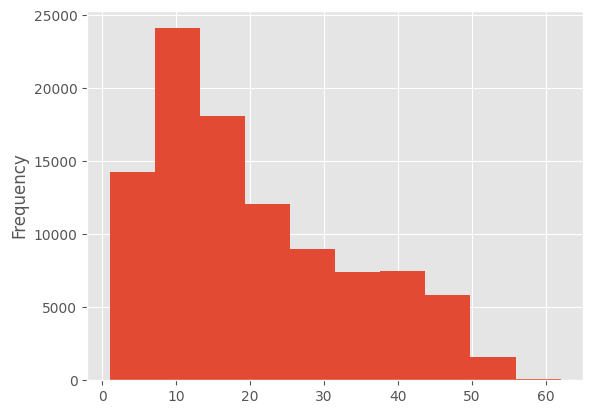

In [13]:
text_length.plot(kind = 'hist')
plt.show()

In [14]:
# More than 50 thousand tweets are around length of 10 words in a sentence which is splitted using white-space.

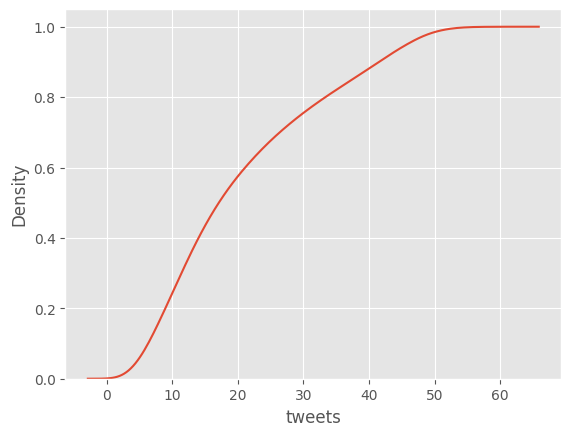

In [15]:
# Lets check the cumulative distribution :
sns.kdeplot(text_length,cumulative = True)
plt.show()

In [16]:
# Roughly 80% of the text length is around 40.

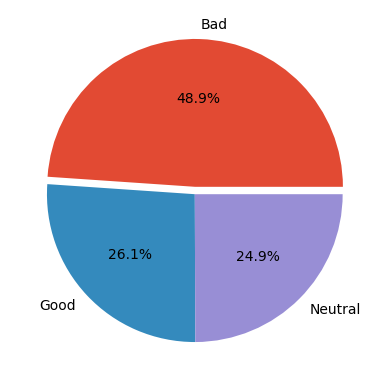

In [17]:
# Lets check the labels features.
plt.pie(df['labels'].value_counts(),labels = ['Bad','Good','Neutral'],radius = 1.0,explode = [0.05,0,0],autopct = '%.1f%%');

In [18]:
# The data is imbalanced as 50% of data belongs to bad category.
# So, as of now we can still go ahead and use this data and build models using neural network with softmax activation function .
# But,Since I want to use the logistics regression and some other algorithms , I am going to merge the good and neutral category together.
# Also change the label to positive and negative.
# This techniques make the problem from multi-class classification problem to Binary classification problem.

In [19]:
df.loc[df['labels']=='neutral','labels'] = 'good'

In [20]:
df['labels'] = df.labels.replace({'good':'positive','bad':'negative'})

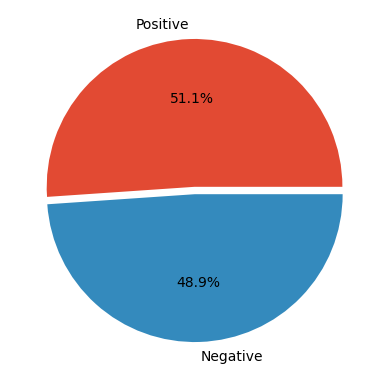

In [21]:
# Lets check the labels features.
plt.pie(df['labels'].value_counts(),labels = ['Positive','Negative'],radius = 1.0,explode = [0.05,0],autopct = '%.1f%%');

In [22]:
# Now we can use the logistics regression as our baseline model.

###  Number of characters in text :

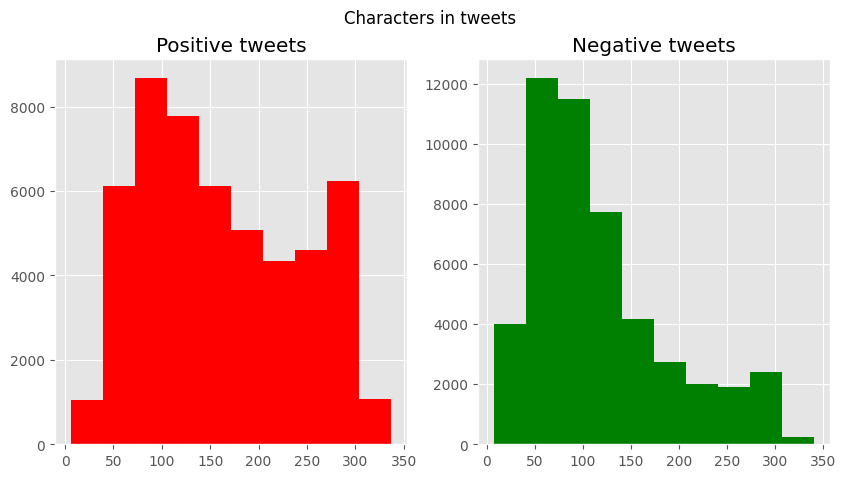

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
tweet_len = df[df['labels']=='positive']['tweets'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Positive tweets')
tweet_len=df[df['labels']=='negative']['tweets'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Negative tweets')
fig.suptitle('Characters in tweets')
plt.show()

In [24]:
# For positive tweets,  most number of tweets contains total number of characters around 75 - 125
# For negative tweets , most number of tweets contains total number of characters around 50-100

### Number of words in a tweet :

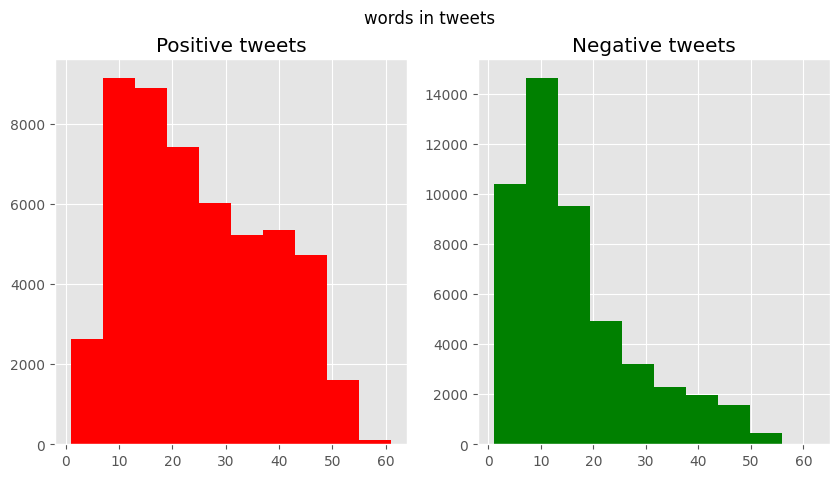

In [25]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
tweet_len = df[df['labels']=='positive']['tweets'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Positive tweets')
tweet_len=df[df['labels']=='negative']['tweets'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Negative tweets')
fig.suptitle('words in tweets')
plt.show()

In [26]:
# For positive tweets, most number of tweets contains total number of words around 10-20
# For negative tweets, most number of tweets contains total number of words around 7-12

###  Average Length of the tweets :

In [27]:
df[df['labels']=='positive']['tweets'].apply(lambda x : len(x.split())).mean()

24.45558470030928

In [28]:
df[df['labels']=='negative']['tweets'].apply(lambda x : len(x.split())).mean()

16.655824508320727

In [29]:
# The length of the positive tweets much larger than negative tweets.

In [30]:
from nltk import FreqDist

In [31]:
def create_corpus(target):
    corpus=[]

    for x in target.str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [32]:
positive = df[df['labels'] == 'positive']['tweets']
corpus=create_corpus(positive)

dic = {}
for word in corpus:
    dic.setdefault(word,1)
    if word in stop:
        dic[word]+=1
    else:
        pass

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

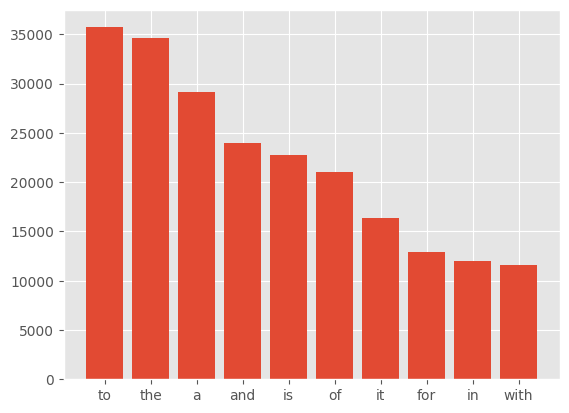

In [33]:
x,y=zip(*top)
plt.bar(x,y)
plt.show()

In [34]:
negative = df[df['labels'] == 'negative']['tweets']
corpus=create_corpus(negative)

dic = {}
for word in corpus:
    dic.setdefault(word,1)
    if word in stop:
        dic[word]+=1
    else:
        pass

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

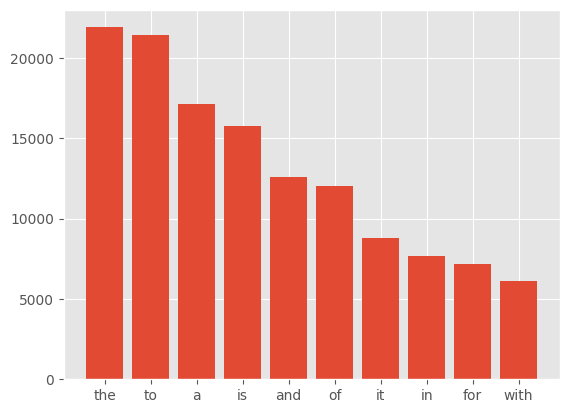

In [35]:
x,y=zip(*top)
plt.bar(x,y)
plt.show()

### Common words :

In [36]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

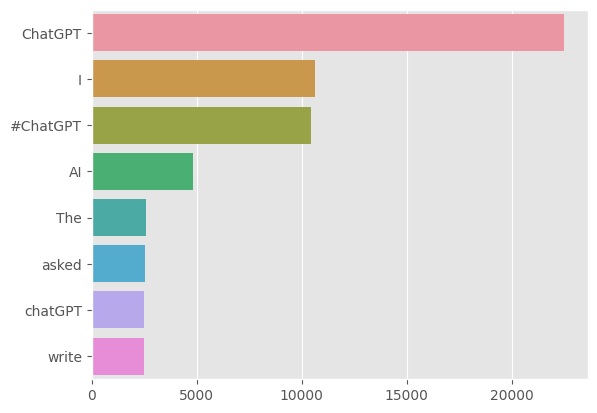

In [37]:
sns.barplot(x=y,y=x);

### **Interpretation :**
* Most of the common words mentioned is 'chatgpt'.
* Also , notice the stop words 'I' mentioned more number of times.

###  Alot of cleaning needed !!

In [38]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

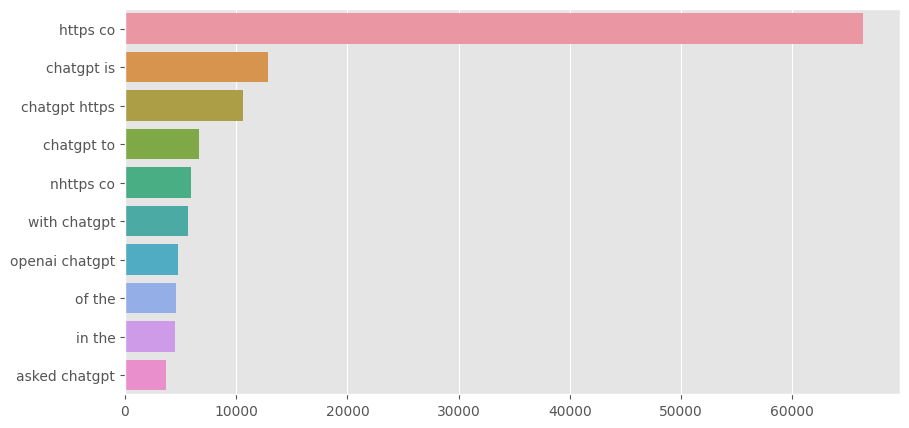

In [39]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df['tweets'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

### **Interpretation :**
    * The dataset contains more url links present in it.
    * This makes sense because each input or record is a tweet.
    * During pre-processing the text , we should get rid of the url links from the text.

###  Data Pre - processing :

In [40]:
# Before training the model, we perform various pre-processing techniques on the data that mainly dealt with removing defined stopwords,
# removing emojis, hastags,html or url links , user handle etc.
# Also, the text will be lower cased for a better generalization.
# The contraction words will be mapped to its extended form.
# Subsequently , the punctuations will be removed and cleaned, therby reducing unnecessary noise from the dataset.
# Atlast , lemmatization will be applied which makes the model robust to similar words such as loving, loved etc.

In [41]:
# A good practice is to always keep the original data aside from the editing or preprocessing step.
data = df.copy()

###  Contraction Mapping :

In [42]:
# Create a mapping to handle contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would",
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have",
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
                       'kg':'kilo grams',"shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       'cr':'crore',"there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                       "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       'yrs':'years',"where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                       "who's": "who is",'bn':'billion','mn':'million', "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                       "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",'ppl':'people' }


In [43]:
def expand_contraction(text):
    expanded_words = [contraction_mapping[word] if word in contraction_mapping else word for word in text.split()]
    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [44]:
data['tweets'] = data['tweets'].map(expand_contraction)

In [45]:
def cleaning_text(data):
    data = re.sub(r'https?://\S+|www\.\S+','',data) # Use to remove url or links
    data = re.sub(r'\\n*',' ',data) # use to replace the newline escape sequence with space
    data = re.sub(r'\xa0',' ',data) # Use to replace the Unicode escape sequence for the non-breaking space character with space
    emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
    "\U0001F700-\U0001F77F"  # Alchemical Symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Extended-A
    "\U0001FA70-\U0001FAFF"  # Extended-B
    "\U0001F004-\U0001F0CF"  # Mahjong Tiles
    "\U0001F170-\U0001F251"  # Enclosed Ideographic Supplement
    "\U0001F92F"             # 🤯
    "]+", flags=re.UNICODE)
    data = emoji_pattern.sub('',data)
    data = re.sub(r'⭐️','',data) # To remove the ⭐️
    data = re.sub(r'⚡️','',data) # To remove the ⚡️
    data = re.sub("(\.\s+)", ' ', str(data)) #remove full stop at end of words(not between)
    data = re.sub("(\-\s+)", ' ', str(data)) #remove - at end of words(not between)
    data = re.sub("(\:\s+)", ' ', str(data)) #remove : at end of words(not between)
    data = re.sub("(\s+)",' ',str(data)) #remove multiple spaces
    data = re.sub("(\s+.\s+)", ' ', str(data)).lower() #remove any single charecters hanging between 2 spaces
    return data

In [46]:
data['tweets'] = data['tweets'].map(cleaning_text)

In [47]:
df['tweets'][58421]

'A new episode is available - Dec 6: Why Isn’t Sam Bankman-Fried Behind Bars Yet? p.s. ChatGPT is 🔥 https://t.co/fJyI1qo6os'

In [48]:
data['tweets'][58421]

'a new episode is available dec why isn’t sam bankman-fried behind bars yet? p.s chatgpt is '

### Removing Punctuation :

In [49]:
def punc_removal(x):
    return re.sub(f"[{re.escape(string.punctuation)}]",' ',x)

In [50]:
data['tweets'] = data['tweets'].map(punc_removal)

In [51]:
df['tweets'][5929]

"I don't normally do the chatbot thing these days but ChatGPT is special. I didn't expect it to know what a ROP2 was let alone even try to decode one, or know what I meant when i said the innermost loop of a blitter, or try to write Verilog. https://t.co/8a61FHZ5oO"

In [52]:
data['tweets'][5929]

'i do not normally do the chatbot thing these days but chatgpt is special did not expect it to know what rop2 was let alone even try to decode one  or know what meant when said the innermost loop of blitter  or try to write verilog '

###  Case Change :

In [53]:
def lower_case(x):
    return x.lower()

In [54]:
data['tweets'] = data['tweets'].map(lower_case)

###  Removing Number :

In [55]:
def cleaning_numbers(x):
    return re.sub('[0-9]+', '', x)

In [56]:
data['tweets'] = data['tweets'].map(cleaning_numbers)

In [57]:
df['tweets'][5929]

"I don't normally do the chatbot thing these days but ChatGPT is special. I didn't expect it to know what a ROP2 was let alone even try to decode one, or know what I meant when i said the innermost loop of a blitter, or try to write Verilog. https://t.co/8a61FHZ5oO"

In [58]:
data['tweets'][5929]

'i do not normally do the chatbot thing these days but chatgpt is special did not expect it to know what rop was let alone even try to decode one  or know what meant when said the innermost loop of blitter  or try to write verilog '

### Stop Words Removal :

In [59]:
# Get the list of all stopwords
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're","you've",
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he','him', 'his', 'himself', 'she', "she's",
    'her', 'hers', 'herself', 'it',"it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
    'am', 'is','are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with','on',
    'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
    'above', 'below', 'to', 'from', 'in', 'out', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where',
    'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
    'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too',
    'very', 's', 't', 'can', 'will', 'just', 'don', 'should', "should've",
    'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn','didn','doesn','hadn','hasn',
     'haven',  'isn',  'ma', 'mightn', 'mustn', 'needn', 'shan','shouldn','wasn','weren','won','wouldn']

In [60]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

In [61]:
data['tweets'] = data['tweets'].map(cleaning_stopwords)

In [62]:
data

,tweets,labels
0,chatgpt optimizing language models dialogue op...,positive
1,try talking chatgpt new ai system optimized di...,positive
2,chatgpt optimizing language models dialogue ai...,positive
3,thrilled share chatgpt new model optimized dia...,positive
4,minutes ago openai released new chatgpt use right,negative
...,...,...
99995,creating short form video content ask chatgpt ...,positive
99996,sonofmosiah openai really market chatgpt much ...,positive
99997,code web apps chatgpt chatgtp ai learn web sol...,negative
99998,actually serve ads profitably off model like c...,positive


### Lemmatization :

In [63]:
lemmat = nltk.stem.WordNetLemmatizer()

In [64]:
def lemmatization(x):
    return ' '.join([lemmat.lemmatize(word) for word in x.split()])

In [65]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [66]:
data['tweets'] = data['tweets'].map(lemmatization)

In [67]:
data['tweets']

0        chatgpt optimizing language model dialogue openai
1        try talking chatgpt new ai system optimized di...
2        chatgpt optimizing language model dialogue ai ...
3        thrilled share chatgpt new model optimized dia...
4         minute ago openai released new chatgpt use right
                               ...                        
99995    creating short form video content ask chatgpt ...
99996    sonofmosiah openai really market chatgpt much ...
99997    code web apps chatgpt chatgtp ai learn web sol...
99998    actually serve ad profitably off model like ch...
99999    chatbot chatgpt writes poetry prose computer c...
Name: tweets, Length: 100000, dtype: object

### Encoding the text into numeric forms :

In [68]:
# Converting labels as positive to 1 and negative to 0.
data.loc[data['labels']=='positive','labels'] = 1
data.loc[data['labels']=='negative','labels'] = 0

In [69]:
data.head()

,tweets,labels
0,chatgpt optimizing language model dialogue openai,1
1,try talking chatgpt new ai system optimized di...,1
2,chatgpt optimizing language model dialogue ai ...,1
3,thrilled share chatgpt new model optimized dia...,1
4,minute ago openai released new chatgpt use right,0


In [70]:
tweets = data['tweets'].to_list()

In [71]:
# Creating vector representation for each tweet.
tfidf = TfidfVectorizer(max_features = 5000)

In [72]:
# Creating the term frequency - inverse document frequency
# This calculates the each term in the each tweet and calculates its importance in the tweet as well as relative the whole tweets.
X = tfidf.fit_transform(tweets)

In [73]:
X

<100000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1017519 stored elements in Compressed Sparse Row format>

In [74]:
labels = data['labels'].to_list()

In [75]:
# Data split into train and validation data
x_train,x_test,y_train,y_test = train_test_split(X,labels,test_size=0.3,random_state=1,shuffle = True)

In [76]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.3,random_state = 1)

In [77]:
precision = {}

##  Baseline Model :

###  Logistic Regression :

In [78]:
# Instantiate the Logistic regression class to create the Logistic regression object.
Lr = LogisticRegression()

In [79]:
# FITTING LOGISTIC REGRESSION
model = Lr.fit(x_train,y_train)

In [80]:
# Predicting the class labels for test data
prediction = Lr.predict(x_val)

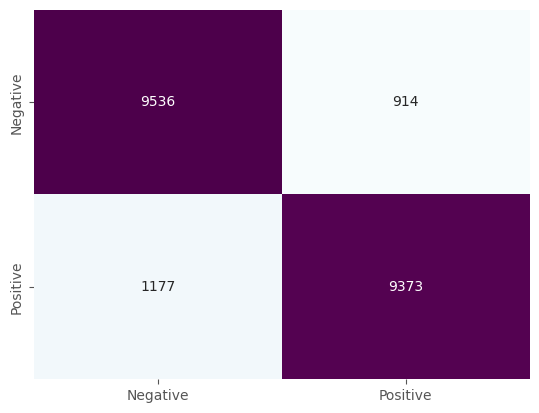

In [81]:
# Confusion matrix to calculate true positive, true negative
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive'],);

In [82]:
# Precision score is important because we dont want to label any negative comments as positive and
# not address the customer's bad experience.
precision['Logistics'] = precision_score(y_val,prediction)
precision['Logistics']

0.9111499951394965

In [83]:
# 91% of the positive predictions made by the model were correct, while 9% were incorrect.

### Decision Tree :

In [84]:
# Instantiate the Decision Tree classifier class to create the Decision Tree object.
dt = DecisionTreeClassifier()

In [85]:
# Fitting the training data
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [86]:
# Prediction made by Decision Tree
prediction = dt.predict(x_val)

In [87]:
# Precision score
precision['Decision Tree'] = precision_score(y_val,prediction)
precision['Decision Tree']

0.8445508307519008

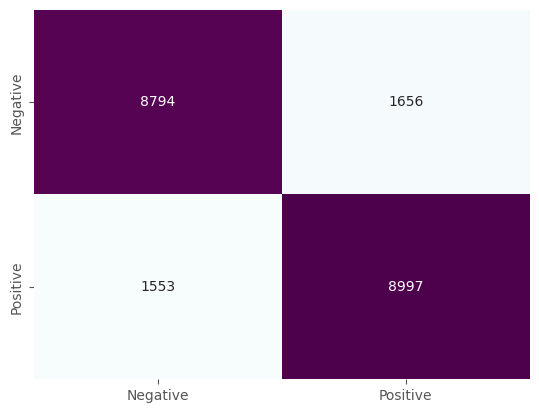

In [88]:
# Confusion matrix for Decision Tree
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive'],);

### Random Forest :

In [89]:
# Instantiate the random forest classifier class to create the random forest object.
rf = RandomForestClassifier()

In [90]:
# Fitting the training data
rf.fit(x_train,y_train)

RandomForestClassifier()

In [91]:
# Prediction made by Random forest
prediction = rf.predict(x_val)

In [92]:
# Precision score
precision['Random Forest'] = precision_score(y_val,prediction)
precision['Random Forest']

0.8598651685393258

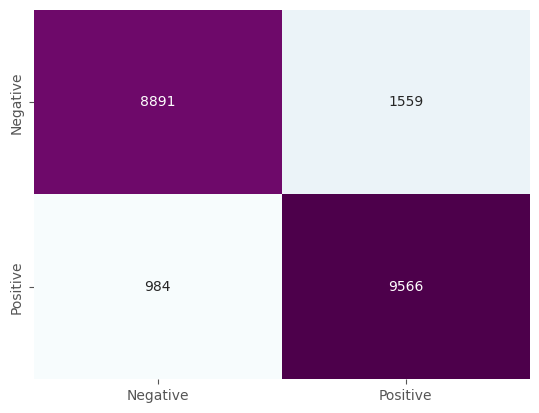

In [93]:
# Confusion matrix for Random Forest
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive'],);

### Support Vector Machine :

In [94]:
from sklearn.svm import SVC

In [95]:
# Instantiate the support vector classifier class to create the support vector object.
svc = SVC()

In [96]:
# Fitting the training data
svc.fit(x_train,y_train)

SVC()

In [97]:
# Prediction made by support vector classifier
prediction = svc.predict(x_val)

In [98]:
# Precision score
precision['Support Vector'] = precision_score(y_val,prediction)
precision['Support Vector']

0.9182353509025968

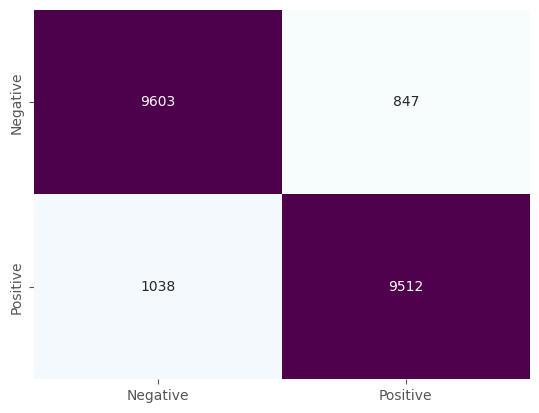

In [99]:
# Confusion matrix for support vector classifier
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive'],);

### Ada-Boost :

In [100]:
# Instantiate the Ada Boost Classifier class to create the Ada Boost object.
adaboost = AdaBoostClassifier()

In [101]:
# Fitting the training data
adaboost.fit(x_train,y_train)

AdaBoostClassifier()

In [102]:
# Prediction made by AdaBoost classifier
prediction = adaboost.predict(x_val)

In [103]:
# Precision score
precision['Ada Boost'] = precision_score(y_val,prediction)
precision['Ada Boost']

0.8869047619047619

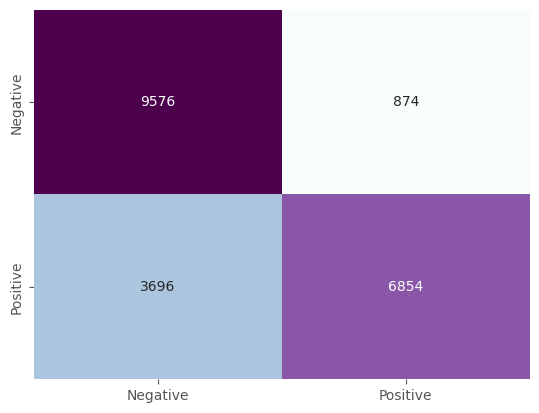

In [104]:
# Confusion matrix for AdaBoost classifier
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive'],);

In [105]:
# Instantiate the xgboost Classifier class to create the Ada Boost object.
xgb = xgboost.XGBClassifier()

In [106]:
# Fitting the training data
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [107]:
# Prediction made by xgboost classifier
prediction = xgb.predict(x_val)

In [108]:
# Precision score
precision['XG Boost']  = precision_score(y_val,prediction)
precision['XG Boost']

0.8969773036293275

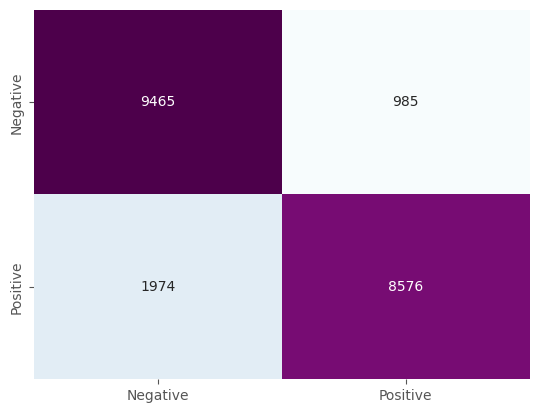

In [109]:
# Confusion matrix for xgboost classifier
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive'],);

###  Deep - Learning :

In [110]:
# Spliting the tweets and labels into train and test
xtrain,xtest,ytrain,ytest = train_test_split(tweets,labels,test_size=0.3,random_state=1)

In [111]:
# Instantiate the tokenizer class
tokenize = Tokenizer()

In [112]:
# Fitting tokenizer into
tokenize.fit_on_texts(xtrain)

In [113]:
# Vocabulary Size
vocab_size = len(tokenize.word_index) + 1
vocab_size

44085

In [114]:
print('Fitted tokenizer on {} tweets'.format(tokenize.document_count))
print('{} words in dictionary'.format(len(tokenize.word_counts)))
print('Top 5 most common words are:', collections.Counter(tokenize.word_counts).most_common(5))

Fitted tokenizer on 70000 tweets
44084 words in dictionary
Top 5 most common words are: [('chatgpt', 73442), ('ai', 13819), ('not', 8963), ('openai', 8950), ('like', 5498)]


### Text to Sequence :

In [115]:
sequence_train = tokenize.texts_to_sequences(xtrain)
sequence_test = tokenize.texts_to_sequences(xtest)

In [116]:
print('"{}" is converted into {}'.format(xtrain[0], sequence_train[0]))

"wasted hour trying build thing top someone else code github giving up would wary copying code chatgpt spit especially not understand" is converted into [5198, 230, 138, 244, 17, 240, 187, 274, 12, 482, 325, 25, 26, 8959, 2151, 12, 1, 1078, 750, 3, 185]


###  Pad Sequence :

In [117]:
# Pad Sequence is to make the length of the each tweets to the same length.

In [118]:
max_length = 45
epoch = 50
batch_size = 128
embedding_dim = 100

In [119]:
X_train = pad_sequences(sequences = sequence_train,maxlen = max_length)
X_test = pad_sequences(sequences = sequence_test,maxlen = max_length)

In [120]:
X_train.shape

(70000, 45)

In [121]:
X_train,X_val,y_train,y_val = train_test_split(X_train,ytrain,test_size=0.3,random_state=1)

In [122]:
# We start with 2 densely connected layer of 64 hidden units. The input_shape for the first layer is equal to the number of words
# As we need to predict the probability between two classes, we can use sigmoid activation in the output layer with one neuron.

### Dense Neural Network :

In [123]:
backend.clear_session()
callback = EarlyStopping(monitor='val_loss', patience=3)
model = Sequential([Dense(units = 64,activation = 'relu',input_shape = (max_length,)),
                   Dense(units = 64,activation = 'relu'),
                   Dense(units = 1,activation = 'sigmoid')])
model.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics = [Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2944      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7169 (28.00 KB)
Trainable params: 7169 (28.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
history = model.fit(np.array(X_train),np.array(y_train),epochs = epoch,batch_size = batch_size,validation_data = (np.array(X_val),np.array(y_val)),callbacks = [callback])

Epoch 1/50
383/383 [==============================] - 9s 7ms/step - loss: 69.8391 - precision: 0.5416 - val_loss: 39.6971 - val_precision: 0.6429
Epoch 2/50
383/383 [==============================] - 2s 4ms/step - loss: 32.1412 - precision: 0.5545 - val_loss: 21.3830 - val_precision: 0.5375
Epoch 3/50
383/383 [==============================] - 2s 4ms/step - loss: 20.2438 - precision: 0.5609 - val_loss: 17.7854 - val_precision: 0.5195
Epoch 4/50
383/383 [==============================] - 2s 5ms/step - loss: 13.7320 - precision: 0.5629 - val_loss: 16.7396 - val_precision: 0.6110
Epoch 5/50
383/383 [==============================] - 2s 5ms/step - loss: 9.3287 - precision: 0.5662 - val_loss: 8.1247 - val_precision: 0.5308
Epoch 6/50
383/383 [==============================] - 2s 5ms/step - loss: 6.0018 - precision: 0.5620 - val_loss: 4.8801 - val_precision: 0.5191
Epoch 7/50
383/383 [==============================] - 2s 6ms/step - loss: 3.6625 - precision: 0.5615 - val_loss: 3.0712 - val_pr

In [125]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1,len(history.epoch)+1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

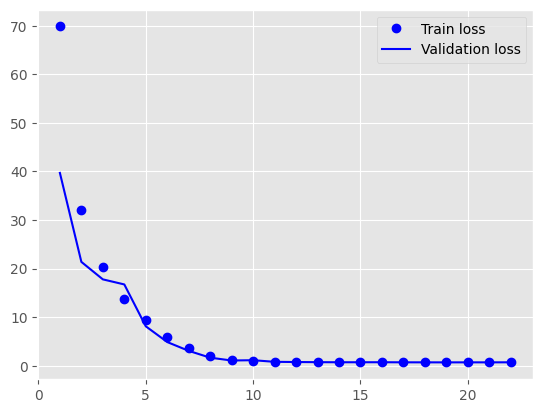

In [126]:
eval_metric(history, 'loss')

In [127]:
prediction = model.predict(X_val)
prediction = list(map(lambda x: 0 if x<0.5 else 1, prediction))

657/657 [==============================] - 1s 2ms/step


In [128]:
precision['Dense NN'] = precision_score(y_val,prediction)
precision['Dense NN']

0.5989703396342401

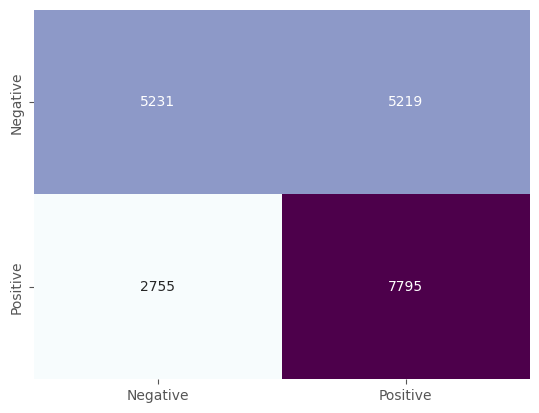

In [129]:
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive'],);

### RNN :

In [130]:
backend.clear_session()
callback = EarlyStopping(monitor='val_loss', patience=3)
rnn = Sequential()
rnn.add(Embedding(vocab_size,embedding_dim,input_length=max_length))
rnn.add(SimpleRNN(units = 64))
rnn.add(Dense(1,activation = 'sigmoid'))
rnn.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics = [Precision()])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 100)           4408500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4419125 (16.86 MB)
Trainable params: 4419125 (16.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [131]:
history = rnn.fit(np.array(X_train),np.array(y_train),epochs = epoch,batch_size = batch_size,validation_data = (np.array(X_val),np.array(y_val)),callbacks = [callback])

Epoch 1/50
383/383 [==============================] - 49s 124ms/step - loss: 0.4389 - precision: 0.8116 - val_loss: 0.3175 - val_precision: 0.9064
Epoch 2/50
383/383 [==============================] - 24s 64ms/step - loss: 0.2352 - precision: 0.9180 - val_loss: 0.2787 - val_precision: 0.8895
Epoch 3/50
383/383 [==============================] - 22s 58ms/step - loss: 0.1614 - precision: 0.9456 - val_loss: 0.2846 - val_precision: 0.9138
Epoch 4/50
383/383 [==============================] - 20s 53ms/step - loss: 0.1039 - precision: 0.9660 - val_loss: 0.3242 - val_precision: 0.8960
Epoch 5/50
383/383 [==============================] - 21s 55ms/step - loss: 0.0672 - precision: 0.9790 - val_loss: 0.4243 - val_precision: 0.9034


In [132]:
prediction = rnn.predict(X_val)
prediction = list(map(lambda x: 0 if x<0.5 else 1, prediction))

657/657 [==============================] - 3s 5ms/step


In [133]:
precision['RNN'] = precision_score(y_val,prediction)
precision['RNN']

0.9034412955465587

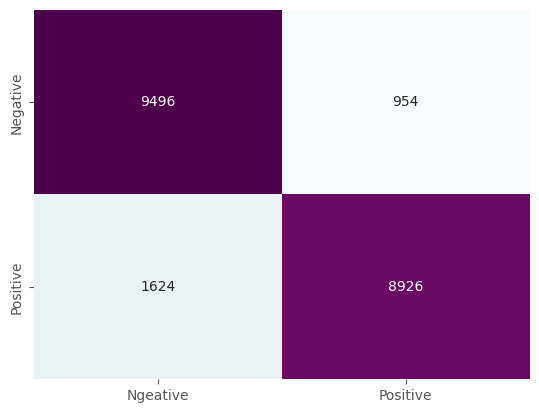

In [134]:
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Ngeative','Positive'],
           yticklabels = ['Negative','Positive'],);

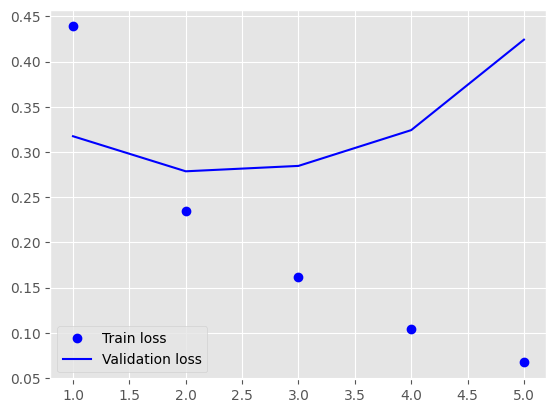

In [135]:
eval_metric(history, 'loss')

In [136]:
# Clearly we can see that the training data is overfitting .
# We now take some measures to deal with over fitting problem.
# 0. Reduce the number of epochs or use early stopping stop training once the model performance stops improving on a hold out validation dataset.
# 1. Reduce the size of the neural network or atleat reduce the size of the number of neurons in the hidden layer.
# 2. Add Dropout layers,which randomly shutoffs a certain percentage of neuron in that hidden layer.
# 3. Add regularization which adds a cost to loss function for larger weights.
# 4. Reducing the number of parameter to train the model should be reduced as well.

### Handling Overfitting :

In [137]:
backend.clear_session()
callback = EarlyStopping(monitor='val_loss', patience=3)
rnn_with_reg = Sequential()
rnn_with_reg.add(Embedding(vocab_size,embedding_dim,input_length=max_length))
rnn_with_reg.add(SimpleRNN(units = 32,kernel_regularizer=l2(0.001)))
rnn_with_reg.add(Dropout(0.5)) # To make the network more robust and generalize .
rnn_with_reg.add(Dense(1,activation = 'sigmoid'))
rnn_with_reg.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics = [Precision()])
rnn_with_reg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 100)           4408500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4412789 (16.83 MB)
Trainable params: 4412789 (16.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [138]:
history = rnn_with_reg.fit(np.array(X_train),np.array(y_train),epochs = epoch,
                    batch_size = batch_size,validation_data = (np.array(X_val),np.array(y_val)),callbacks = [callback])

Epoch 1/50
383/383 [==============================] - 39s 96ms/step - loss: 0.4975 - precision: 0.8051 - val_loss: 0.3504 - val_precision: 0.8809
Epoch 2/50
383/383 [==============================] - 25s 66ms/step - loss: 0.2945 - precision: 0.9105 - val_loss: 0.3157 - val_precision: 0.8859
Epoch 3/50
383/383 [==============================] - 21s 54ms/step - loss: 0.2287 - precision: 0.9328 - val_loss: 0.2982 - val_precision: 0.9150
Epoch 4/50
383/383 [==============================] - 22s 57ms/step - loss: 0.1850 - precision: 0.9477 - val_loss: 0.2896 - val_precision: 0.9177
Epoch 5/50
383/383 [==============================] - 21s 54ms/step - loss: 0.1497 - precision: 0.9582 - val_loss: 0.3023 - val_precision: 0.8973
Epoch 6/50
383/383 [==============================] - 21s 55ms/step - loss: 0.1192 - precision: 0.9693 - val_loss: 0.3298 - val_precision: 0.9071
Epoch 7/50
383/383 [==============================] - 20s 53ms/step - loss: 0.0938 - precision: 0.9775 - val_loss: 0.3689 - 

In [139]:
prediction = rnn_with_reg.predict(X_val)
prediction = list(map(lambda x: 0 if x<0.5 else 1, prediction))

657/657 [==============================] - 3s 5ms/step


In [140]:
precision['RNN WITH REG'] = precision_score(y_val,prediction)
precision['RNN WITH REG']

0.9011546043368065

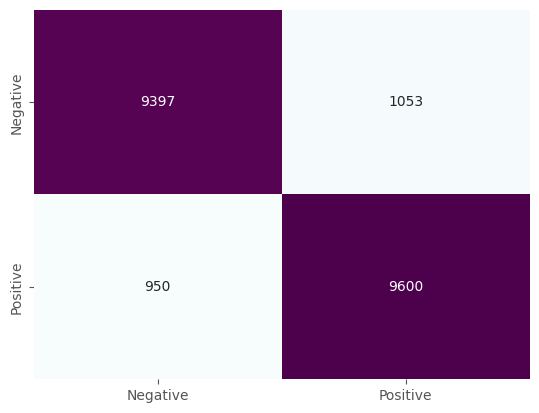

In [141]:
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive'],);

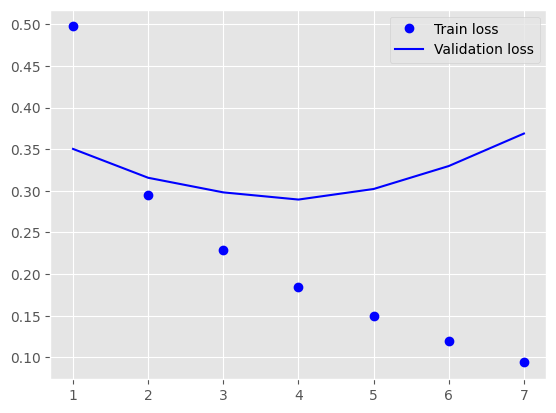

In [142]:
eval_metric(history,'loss')

### LSTM :

* LSTM networks are the most commonly used variation of Recurrent Neural Networks (RNNs).
* The critical component of the LSTM is the memory cell and the gates (including the forget gate but also the input gate), inner contents of the memory cell are modulated by the input gates and forget gates.
* Assuming that both of the gates are closed, the contents of the memory cell will remain unmodified between one time-step and
    the next gradients gating structure allows information to be retained across many time-steps, and consequently also allows group that to flow across many time-steps.
* This allows the LSTM model to overcome the vanishing gradient properly occurs with most Recurrent Neural Network models.

In [143]:
backend.clear_session()
callback = EarlyStopping(monitor='val_loss', patience=3)
lstm = Sequential()
lstm.add(Embedding(vocab_size,embedding_dim,input_length=max_length))
lstm.add(LSTM(units = 32))
lstm.add(Dropout(0.5))
lstm.add(Dense(1,activation = 'sigmoid'))
lstm.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics = [Precision()])
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 100)           4408500   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4425557 (16.88 MB)
Trainable params: 4425557 (16.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [144]:
history = lstm.fit(np.array(X_train),np.array(y_train),epochs = epoch,
                    batch_size = batch_size,validation_data = (np.array(X_val),np.array(y_val)),callbacks = [callback])

Epoch 1/50
383/383 [==============================] - 27s 60ms/step - loss: 0.4633 - precision: 0.8040 - val_loss: 0.3142 - val_precision: 0.8975
Epoch 2/50
383/383 [==============================] - 7s 19ms/step - loss: 0.2533 - precision: 0.9101 - val_loss: 0.2556 - val_precision: 0.9063
Epoch 3/50
383/383 [==============================] - 6s 15ms/step - loss: 0.1905 - precision: 0.9345 - val_loss: 0.2566 - val_precision: 0.8824
Epoch 4/50
383/383 [==============================] - 4s 11ms/step - loss: 0.1543 - precision: 0.9473 - val_loss: 0.2444 - val_precision: 0.9201
Epoch 5/50
383/383 [==============================] - 4s 12ms/step - loss: 0.1326 - precision: 0.9559 - val_loss: 0.2517 - val_precision: 0.9218
Epoch 6/50
383/383 [==============================] - 4s 10ms/step - loss: 0.1149 - precision: 0.9625 - val_loss: 0.2469 - val_precision: 0.9059
Epoch 7/50
383/383 [==============================] - 4s 10ms/step - loss: 0.1017 - precision: 0.9670 - val_loss: 0.2553 - val_pr

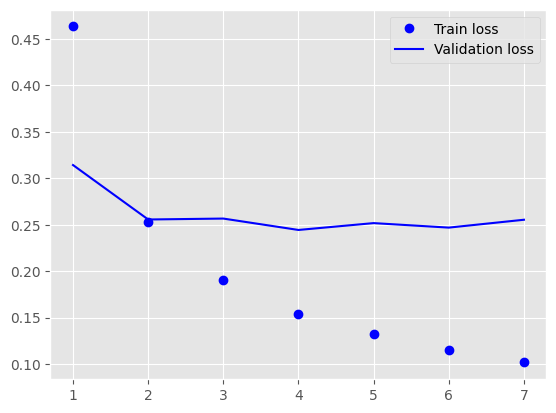

In [145]:
eval_metric(history,'loss')

In [146]:
prediction = lstm.predict(X_val)
prediction = list(map(lambda x: 0 if x<0.5 else 1, prediction))

657/657 [==============================] - 2s 2ms/step


In [147]:
precision['LSTM'] = precision_score(y_val,prediction)
precision['LSTM']

0.9116166324818199

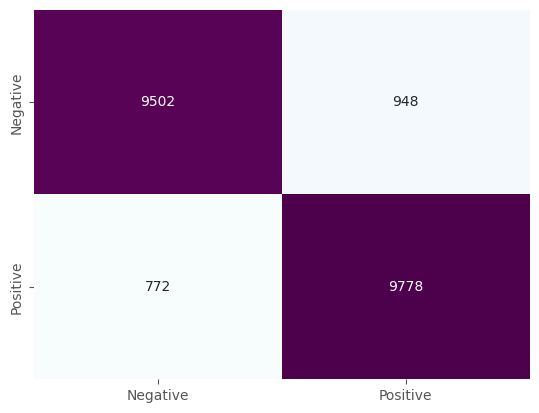

In [148]:
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive']);

###  Bi-directional LSTM :

* Bidirectional recurrent neural networks(LSTM) are really just putting two independent LSTM together.
* This structure allows the networks to have both backward and forward information about the sequence at every time step
* Using bidirectional will run your inputs in two ways, one from past to future and one from future to past and
what differs this approach from unidirectional is that in the LSTM that runs backward you preserve information
from the future and using the two hidden states combined you are able in any point in time to preserve information
from both past and future.

In [149]:
backend.clear_session()
callback = EarlyStopping(monitor='val_loss', patience=3)
bi_lstm = Sequential()
bi_lstm.add(Embedding(vocab_size,embedding_dim,input_length=max_length))
bi_lstm.add(Bidirectional(LSTM(units = 32)))
bi_lstm.add(Dropout(0.5))
bi_lstm.add(Dense(1,activation = 'sigmoid'))
bi_lstm.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics = [Precision()])
bi_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 100)           4408500   
                                                                 
 bidirectional (Bidirection  (None, 64)                34048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4442613 (16.95 MB)
Trainable params: 4442613 (16.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [150]:
history = bi_lstm.fit(np.array(X_train),np.array(y_train),epochs = epoch,
                    batch_size = batch_size,validation_data = (np.array(X_val),np.array(y_val)),callbacks = [callback])

Epoch 1/50
383/383 [==============================] - 29s 65ms/step - loss: 0.4923 - precision: 0.7733 - val_loss: 0.3237 - val_precision: 0.8826
Epoch 2/50
383/383 [==============================] - 8s 21ms/step - loss: 0.2613 - precision: 0.9059 - val_loss: 0.2597 - val_precision: 0.9073
Epoch 3/50
383/383 [==============================] - 7s 18ms/step - loss: 0.1924 - precision: 0.9318 - val_loss: 0.2435 - val_precision: 0.9009
Epoch 4/50
383/383 [==============================] - 4s 12ms/step - loss: 0.1585 - precision: 0.9432 - val_loss: 0.2362 - val_precision: 0.9060
Epoch 5/50
383/383 [==============================] - 6s 15ms/step - loss: 0.1312 - precision: 0.9550 - val_loss: 0.2391 - val_precision: 0.9180
Epoch 6/50
383/383 [==============================] - 4s 12ms/step - loss: 0.1127 - precision: 0.9626 - val_loss: 0.2423 - val_precision: 0.9140
Epoch 7/50
383/383 [==============================] - 5s 13ms/step - loss: 0.0988 - precision: 0.9671 - val_loss: 0.2605 - val_pr

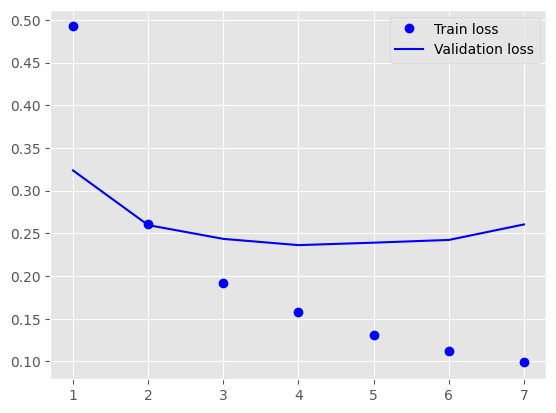

In [151]:
eval_metric(history,'loss')

In [152]:
prediction = bi_lstm.predict(X_val)
prediction = list(map(lambda x: 0 if x<0.5 else 1, prediction))

657/657 [==============================] - 3s 4ms/step


In [153]:
precision['Bi-LSTM'] = precision_score(y_val,prediction)
precision['Bi-LSTM']

0.9281032964883107

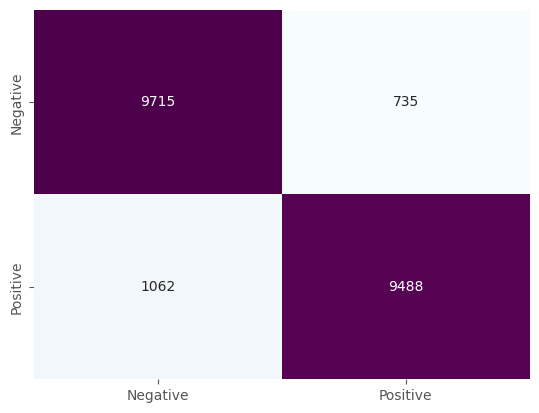

In [154]:
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive']);

## GRU :

* Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) that was introduced by Cho et al. in 2014 as a simpler alternative to Long Short-Term Memory (LSTM) networks.
* Like LSTM, GRU can process sequential data such as text, speech, and time-series data.
* The basic idea behind GRU is to use gating mechanisms to selectively update the hidden state of the network at each time step.
* The gating mechanisms are used to control the flow of information in and out of the network.
* The GRU has two gating mechanisms, called the reset gate and the update gate.
* The reset gate determines how much of the previous hidden state should be forgotten, while the update gate determines how much of the new input should be used to update the hidden state.
* The output of the GRU is calculated based on the updated hidden state.

In [155]:
backend.clear_session()
callback = EarlyStopping(monitor='val_loss', patience=3)
gru = Sequential()
gru.add(Embedding(vocab_size,embedding_dim,input_length=max_length))
gru.add(GRU(units = 32,activation = 'relu'))
gru.add(Dropout(0.5))
gru.add(Dense(1,activation = 'sigmoid'))
gru.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics = [Precision()])
gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 100)           4408500   
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4421397 (16.87 MB)
Trainable params: 4421397 (16.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [156]:
history = gru.fit(np.array(X_train),np.array(y_train),epochs = epoch,
                    batch_size = batch_size,validation_data = (np.array(X_val),np.array(y_val)),callbacks = [callback])

Epoch 1/50
383/383 [==============================] - 65s 165ms/step - loss: 0.4999 - precision: 0.7340 - val_loss: 0.3068 - val_precision: 0.8657
Epoch 2/50
383/383 [==============================] - 48s 125ms/step - loss: 0.2688 - precision: 0.8989 - val_loss: 0.2529 - val_precision: 0.8937
Epoch 3/50
383/383 [==============================] - 45s 116ms/step - loss: 0.2064 - precision: 0.9257 - val_loss: 0.2403 - val_precision: 0.9187
Epoch 4/50
383/383 [==============================] - 45s 116ms/step - loss: 0.1683 - precision: 0.9419 - val_loss: 0.2344 - val_precision: 0.9132
Epoch 5/50
383/383 [==============================] - 43s 111ms/step - loss: 0.1444 - precision: 0.9510 - val_loss: 0.2341 - val_precision: 0.9205
Epoch 6/50
383/383 [==============================] - 43s 113ms/step - loss: 0.1239 - precision: 0.9588 - val_loss: 0.2483 - val_precision: 0.9121
Epoch 7/50
383/383 [==============================] - 42s 109ms/step - loss: 0.1073 - precision: 0.9643 - val_loss: 0.

In [157]:
prediction = gru.predict(X_val)
prediction = list(map(lambda x: 0 if x<0.5 else 1, prediction))

657/657 [==============================] - 6s 8ms/step


In [158]:
precision['GRU'] = precision_score(y_val,prediction)
precision['GRU']

0.9116032381129617

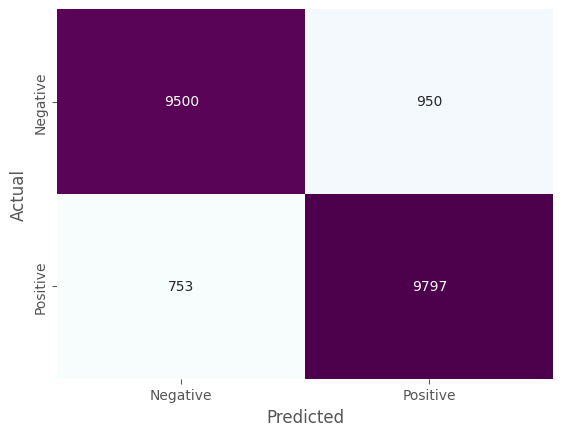

In [159]:
sns.heatmap(confusion_matrix(y_val,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual');

### Score card :

In [160]:
score = pd.DataFrame(precision.values(),precision.keys(),columns = ['Precision Score'])
score.sort_values(by = 'Precision Score' ,ascending = False)

,Precision Score
Bi-LSTM,0.928103
Support Vector,0.918235
LSTM,0.911617
GRU,0.911603
Logistics,0.911150
RNN,0.903441
RNN WITH REG,0.901155
XG Boost,0.896977
Ada Boost,0.886905
Random Forest,0.859865


In [ ]:
# Its obvious that Bi-LSTM algorithm performs better than all the other.
# So let's use that as a final model.

### Prediction using Bi-LSTM :

In [161]:
prediction = bi_lstm.predict(X_test)
prediction = list(map(lambda x: 0 if x<0.5 else 1, prediction))

938/938 [==============================] - 5s 5ms/step


In [162]:
precision_score(ytest,prediction)

0.9296144270237534

### The Bi-LSTM algorithm has achieved a precision score of 0.93 for our test data.

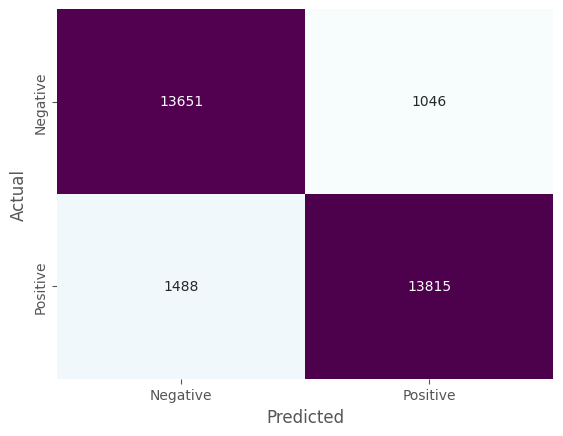

In [163]:
sns.heatmap(confusion_matrix(ytest,prediction),fmt = 'd',annot = True,cbar = False,cmap = 'BuPu',xticklabels = ['Negative','Positive'],
           yticklabels = ['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual');

## Summary :
**Project Overview:**
Our project centered on sentiment analysis of tweets related to ChatGPT, aiming to determine whether each tweet carries a positive or negative sentiment.

**1. Exploratory Data Analysis (EDA):**
In the initial phase, we conducted exploratory data analysis to gain insights into the tweet data and class distribution. Notably, we observed an abundance of stop words, URLs, and user handles within the tweets.

**2. Data Preprocessing:**
To prepare the data for analysis, we engaged in meticulous data preprocessing. This included the removal of predetermined stop words, conversion of contraction words to their original forms, and the application of lemmatization techniques to normalize words to their grammatical base form.

**3. Vectorization:**
In the vectorization phase, we explored the use of TF-IDF (Term Frequency-Inverse Document Frequency) to transform the tweet text into numerical vectors. We established a baseline model using logistic regression and subsequently experimented with decision trees, random forests, AdaBoost, and XGBoost.

**4. Advanced Model Building:**
To enhance our sentiment analysis model, we ventured into more sophisticated techniques, focusing on capturing the semantic meaning of words. We employed word embedding techniques and developed a range of models, including dense neural networks, recurrent neural networks (RNNs), LSTMs (Long Short-Term Memory), bi-directional RNNs and LSTMs. Ultimately, we found that the Bi-LSTM neural network provided exceptional results, achieving a precision score of 0.93 on the test data.

**5. Room for Improvement:**
While our project yielded promising results, there are opportunities for further enhancement. We can utilize tools like Keras Tuner to optimize the architecture of the Bi-LSTM neural network, determining the ideal number of layers and neurons. Additionally, exploring transformer-based models and transfer learning techniques may lead to even better sentiment analysis outcomes in the future.